# Projet Kit BGD INFMDI721 : Données du Vendée Globe 2020-2021

**Sources des données**

* Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
* Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire

## Récupération des données

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import datetime
import time
import os

In [2]:
# variables de config
DOWNLOAD = False  # si True, on download tous les fichiers de race data
EXCEL_PATH = "data/excels/"  # repertoire des fichiers excel downloadés
LOAD_EXCEL = False  # si True, on lit tous les fichiers excel avec pd.read_excel, sinon on load le pickle
HTML_DISPLAY = True  # si True, on affiche la carte enregistrée au format HTML

In [3]:
# start: 2020-11 08-14:00:00
# stop: 2021-03-05 08:00:00
# format: 20210305_080000

if DOWNLOAD:
    base_url = "https://www.vendeeglobe.org/download-race-data/"

    hours = ['040000', '080000', '110000', '140000', '170000', '210000']

    curr_date = datetime.date(2020, 11, 8)

    i = 0
    while curr_date < datetime.date(2021, 3, 5):
        curr_date = datetime.date(2020, 11, 8) + datetime.timedelta(days=i)
        for hour in hours:
            curr_file = curr_date.strftime("%Y%m%d") + "_" + hour + ".xlsx"
            full_filename = "vendeeglobe_" + curr_file
            full_url = base_url + full_filename
            req = requests.get(full_url)
            if req.status_code == 200:
                with open(EXCEL_PATH + curr_file, 'wb') as f:
                    f.write(req.content)
            else:
                print(f"Error on {filename}: {req.status_code}")
            # time.sleep(1)
        i += 1

In [4]:
# premier fichier utilisable: 20201108_140000
# dernier fichier utilisable: 20210127_140000 -- Après ça, le premier est arrivé et le format change

if LOAD_EXCEL:
    all_dfs = []
    hours = ['040000', '080000', '110000', '140000', '170000', '210000']
    H = len(hours)
    curr_date = datetime.date(2020, 11, 8)
    i = 0
    j = 3

    while curr_date < datetime.date(2021, 1, 27):
        curr_date = datetime.date(2020, 11, 8) + datetime.timedelta(days=i)
        curr_file = curr_date.strftime("%Y%m%d") + "_" + hours[j%H] + ".xlsx"
        df = pd.read_excel(EXCEL_PATH + curr_file,
                           skiprows=4, nrows=33, usecols=[x for x in range(1,21)],
                           names=["Rank", "Nat. Sail", "Skipper / Crew", "Hour FR", "Lat", "Long", "Head_l30min", "Speed_l30min",
                                  "VMG_l30min", "Dist_l30min", "Head_lrep", "Speed_lrep", "VMG_lrep", "Dist_lrep", "Head_l24h",
                                  "Speed_l24h", "VMG_l24h", "Dist_l24h", "DTF", "DTL"])
        df['date'] = curr_date
        all_dfs.append(df)
        j += 1
        if (j % H) == 0:
            i +=1

    vg_df = pd.concat(all_dfs, axis=0)
    del all_dfs
    vg_df.to_pickle("data/vg_df.pkl")

else:
    vg_df = pd.read_pickle("data/vg_df.pkl")

vg_df.head()    

,Rank,Nat. Sail,Skipper / Crew,Hour FR,Lat,Long,Head_l30min,Speed_l30min,VMG_l30min,Dist_l30min,...,Speed_lrep,VMG_lrep,Dist_lrep,Head_l24h,Speed_l24h,VMG_l24h,Dist_l24h,DTF,DTL,date
0,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,0.3 nm,...,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,2020-11-08
1,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,0.4 nm,...,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,2020-11-08
2,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,0.5 nm,...,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,2020-11-08
3,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,0.7 nm,...,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,2020-11-08
4,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,0.2 nm,...,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,2020-11-08


##### Glossaire des acronymes :
* **VMG** : Velocity Made Good = projection du vecteur vitesse sur la route théorique (ie vitesse de rapprochement au but);
* **DTF** : Distance To Finish = Distance théorique la plus courte pour rejoindre l'arrivée;
* **DTL** : Distance To Leader = différence de distance au but avec le premier au classement.

## Nettoyage des données et mise en forme

In [5]:
vg_df["Nat"] = vg_df["Nat. Sail"].apply(lambda x: x.split()[0].strip("\n"))
vg_df["Sail"] = vg_df["Nat. Sail"].apply(lambda x: x.split()[1])
vg_df["Skipper"] = vg_df["Skipper / Crew"].apply(lambda x: x.split("\n")[0])
vg_df["Crew"] = vg_df["Skipper / Crew"].apply(lambda x: x.split("\n")[1])
vg_df["Hour"] = vg_df["Hour FR"].apply(lambda x: str(x).split()[0])
# On ajoute une colonne pour indiquer si le participant a abandonné
vg_df["Retired"] = 0
mask = vg_df["Rank"].isin(["RET", "NL"])
vg_df.loc[mask, "Retired"] = 1
# On transforme le Rank en numérique en mettant les participants "Retired" en dernier
vg_df["Rank"] = vg_df["Rank"].replace(["NL", "RET"], "33").astype(int)
# fix nan values in "Hour"
vg_df.loc[vg_df["Hour"] == "nan", "Hour"] = np.nan
vg_df["Hour"] = vg_df["Hour"].fillna(method="ffill")
#df["TZ"] = df["Hour FR"].apply(lambda x: str(x).split()[1].strip("\n"))


In [6]:
# on extrait uniquement les valeurs numériques sans les unités pour les colonnes 6 à 19
for col_num in range(6, 20):
    vg_df.iloc[:, col_num] = vg_df.iloc[:, col_num].str.extract("([0-9.]+)").astype(float)

In [7]:
import re
# convertisseur lat/long en décimal
def convlatlong(x: str) -> float:
    m = re.match(r"(\d+)\D(\d+)\D(\d+)\D(N|S|E|W)", str(x))
    if m is not None:
        deg = int(m.group(1))
        mins = int(m.group(2))
        sec = int(m.group(3))
        orient = m.group(4)
        latlong_dec = deg + mins / 60 + sec / 3600
        if (orient == "S") or (orient == "W"):
            latlong_dec *= -1
    else:
        latlong_dec = np.nan
    return latlong_dec

vg_df["Lat_dec"] = vg_df["Lat"].apply(convlatlong)
vg_df["Long_dec"] = vg_df["Long"].apply(convlatlong)

In [8]:
# réalisation d'un datetime index
vg_df["date_time"] = [str(x) + " " + str(y) for x, y in zip(vg_df["date"], vg_df["Hour"])]
vg_df = vg_df.set_index(pd.to_datetime(vg_df["date_time"])).sort_index()


In [9]:
# on drop les colonnes inutiles
vg_df = vg_df.drop(["Nat. Sail", "Skipper / Crew", "Hour FR", "Lat", "Long", "date", "Hour", "date_time"], axis=1)

In [10]:
vg_df

,Rank,Head_l30min,Speed_l30min,VMG_l30min,Dist_l30min,Head_lrep,Speed_lrep,VMG_lrep,Dist_lrep,Head_l24h,...,Dist_l24h,DTF,DTL,Nat,Sail,Skipper,Crew,Retired,Lat_dec,Long_dec
date_time,,,,,,,,,,,,,,,,,,,,,
2020-11-08 15:26:00,28,238.0,13.8,13.5,0.2,358.0,0.0,0.0,2788.5,187.0,...,5.2,24295.5,1.6,FRA,27,Isabelle Joschke,MACSF,0,46.427222,-1.806111
2020-11-08 15:27:00,20,241.0,22.3,22.3,0.4,357.0,0.0,0.0,2789.3,195.0,...,4.5,24295.2,1.4,FRA,6,Nicolas Troussel,CORUM L'Épargne,0,46.438889,-1.821944
2020-11-08 15:28:00,30,237.0,11.4,11.3,0.4,358.0,0.0,0.0,2788.9,188.0,...,4.8,24295.6,1.7,FRA,50,Miranda Merron,Campagne de France,0,46.427500,-1.809444
2020-11-08 15:28:00,26,242.0,12.6,12.6,0.6,358.0,0.0,0.0,2788.9,190.0,...,4.8,24295.4,1.5,FR,FRA,Armel Tripon,L'Occitane en Provence,0,46.426667,-1.817500
2020-11-08 15:28:00,14,232.0,7.5,7.2,2.7,357.0,0.0,0.0,2788.4,192.0,...,5.4,24294.9,1.1,FRA,1000,Damien Seguin,Groupe APICIL,0,46.423333,-1.817222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 04:30:00,12,38.0,12.0,12.0,6.0,29.0,12.4,12.2,87.1,28.0,...,303.0,1772.0,1511.0,FRA,30,Clarisse Cremer,Banque Populaire X,0,26.945000,-29.848333
2021-01-27 04:30:00,13,2.0,12.7,11.1,6.4,345.0,12.3,8.7,85.9,342.0,...,302.8,2661.8,2400.7,FRA,49,Romain Attanasio,Pure - Best Western Hotels and Resorts,0,12.203611,-34.958889
2021-01-27 04:30:00,14,346.0,16.1,12.2,8.1,347.0,16.1,12.5,112.5,356.0,...,247.5,2895.2,2634.2,FRA,8,Jérémie Beyou,Charal,0,7.068056,-33.655000


## Traitement des valeurs manquantes

In [11]:
# affichage du nombre de valeurs manquantes par colonnes
vg_df.isna().sum()

Rank               0
Head_l30min     2178
Speed_l30min    2178
VMG_l30min      2178
Dist_l30min     2178
Head_lrep       2178
Speed_lrep      2178
VMG_lrep        2178
Dist_lrep       2178
Head_l24h       2178
Speed_l24h      2178
VMG_l24h        2178
Dist_l24h       2178
DTF             2178
DTL             2178
Nat                0
Sail               0
Skipper            0
Crew               0
Retired            0
Lat_dec         2178
Long_dec        2178
dtype: int64

In [12]:
# On va remplir les données manquantes de Latitude et Longitude par la dernière position connue du Skipper
# même chose pour DTF et DTL
vg_df[["Lat_dec", "Long_dec", "DTF", "DTL"]] = vg_df.groupby(
    "Skipper")[["Lat_dec", "Long_dec", "DTF", "DTL"]].transform("ffill")
# si besoin on fill avec la prochaine position connue
vg_df[["Lat_dec", "Long_dec", "DTF", "DTL"]] = vg_df.groupby(
    "Skipper")[["Lat_dec", "Long_dec", "DTF", "DTL"]].transform("bfill")

In [13]:
# On remplit les valeurs manquantes de Heading, Speed, VMG and Distance avec 0
vg_df.iloc[:, 1:13] = vg_df.iloc[:, 1:13].fillna(0)

In [14]:
# On verifie qu'il n'y a plus de valeurs manquantes
vg_df.isna().sum().sum()

0

## Exploration visuelle des données

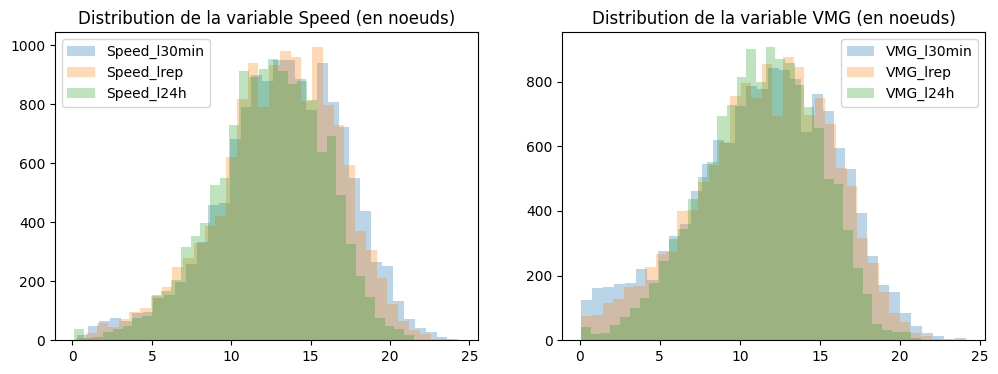

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

lags = ["_l30min", "_lrep", "_l24h"]
cols = ["Speed", "VMG"]

fig = plt.figure(figsize=(12,  4))
for i, col in enumerate(cols):
    fig.add_subplot(1,2,i+1)
    for lag in lags:
        # on ignore les valeurs == 0 (car elles proviennent du fillna)
        mask = vg_df[f"{col}{lag}"] != 0
        plt.hist(vg_df.loc[mask, f"{col}{lag}"], bins=35, alpha=0.3, label=f"{col}{lag}")
        plt.title(f"Distribution de la variable {col} (en noeuds)")
        plt.legend()
plt.show()

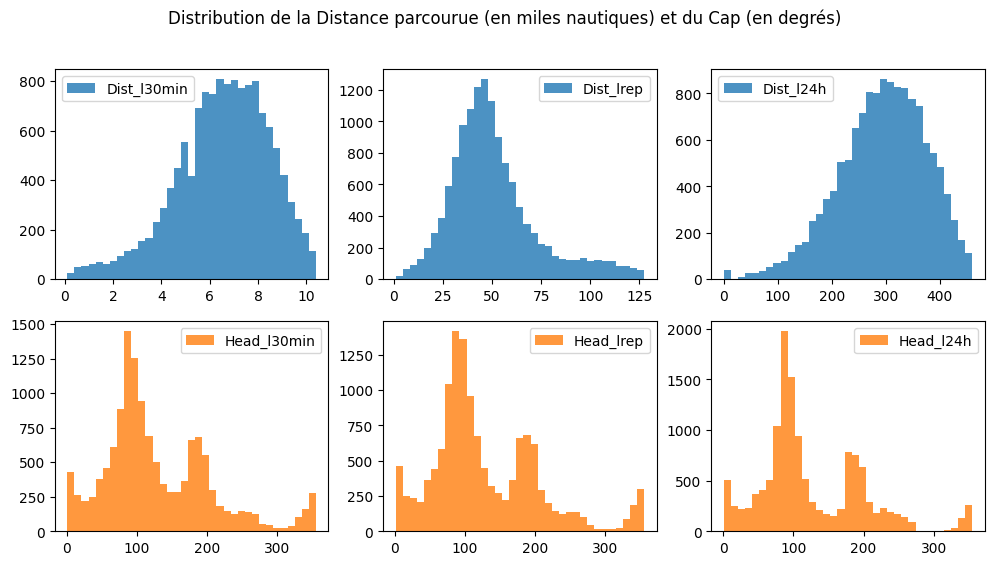

In [16]:
lags = ["_l30min", "_lrep", "_l24h"]
cols = ["Dist", "Head"]


fig = plt.figure(figsize=(12,  6))
i = 0
for col in cols:
    for lag in lags:
        # on ignore les valeurs == 0 et on retire les outliers pour que le plot soit plus visuel
        mask = (vg_df[f"{col}{lag}"] != 0) & (vg_df[f"{col}{lag}"] < np.nanpercentile(vg_df[f"{col}{lag}"], 99))
        plot_dist = vg_df.loc[mask, f"{col}{lag}"]
        fig.add_subplot(2,3,i+1)
        if col == "Head":
            color = "C1"
        else:
            color = "C0"
        plt.hist(plot_dist, bins=35, alpha=0.8, label=f"{col}{lag}", color=color)
        plt.legend()
        i += 1

plt.suptitle(f"Distribution de la Distance parcourue (en miles nautiques) et du Cap (en degrés)")
plt.show()

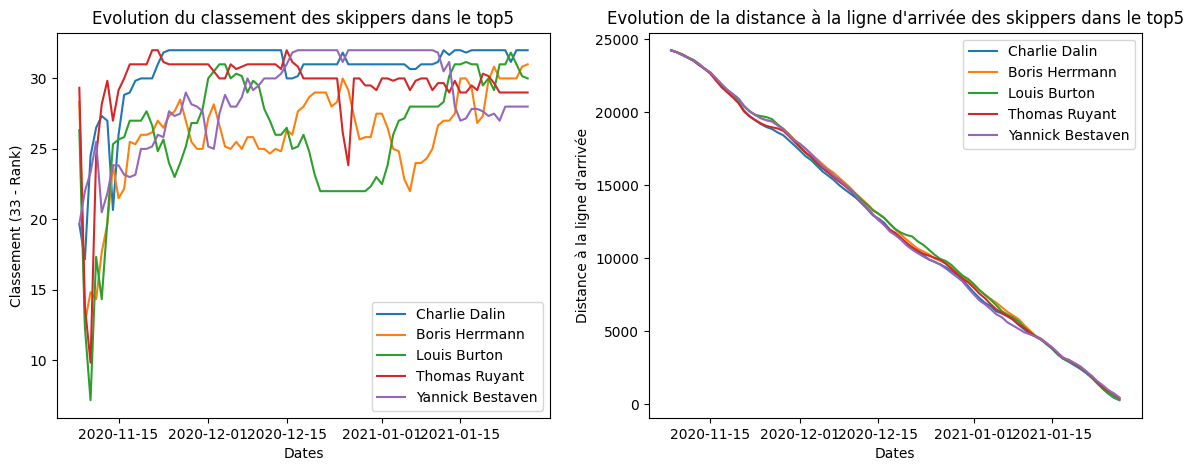

In [17]:
# On selectionne les skippers qui sont dans le TOP_N au dernier timestamp
TOP_N = 5
MAX_VAL = vg_df["Skipper"].nunique()

top_df = vg_df.loc[(vg_df.index == vg_df.index.max()) & (vg_df["Rank"] <= TOP_N), "Skipper"]

fig = plt.figure(figsize=(14,5))
# plot de l'évolution des rank au cours du temps
fig.add_subplot(121)
for skipper in top_df:
    plot_skip = MAX_VAL - vg_df[vg_df["Skipper"] == skipper].resample("D")["Rank"].mean()
    plt.plot(plot_skip, label=skipper,)
plt.xlabel("Dates")
plt.ylabel("Classement (33 - Rank)")
plt.title(f"Evolution du classement des skippers dans le top{TOP_N}")
plt.legend()

# plot de l'évolution de la distance à l'arrivée au cours du temps
fig.add_subplot(122)
for skipper in top_df:
    plot_skip = vg_df[vg_df["Skipper"] == skipper].resample("D")["DTF"].mean()
    plt.plot(plot_skip, label=skipper,)
plt.xlabel("Dates")
plt.ylabel("Distance à la ligne d'arrivée")
plt.title(f"Evolution de la distance à la ligne d'arrivée des skippers dans le top{TOP_N}")
plt.legend()
plt.show()

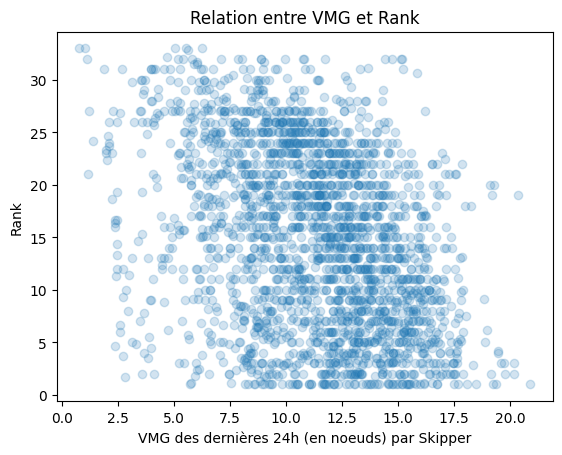

In [18]:
mask = vg_df["VMG_l24h"] != 0
plt.scatter(
    x=vg_df.loc[mask, :].groupby("Skipper")["VMG_l24h"].resample("D").mean(),
    y=vg_df.loc[mask, :].groupby("Skipper")["Rank"].resample("D").mean(),
    alpha=0.2
)
plt.xlabel("VMG des dernières 24h (en noeuds) par Skipper")
plt.ylabel("Rank")
plt.title("Relation entre VMG et Rank")
plt.show()


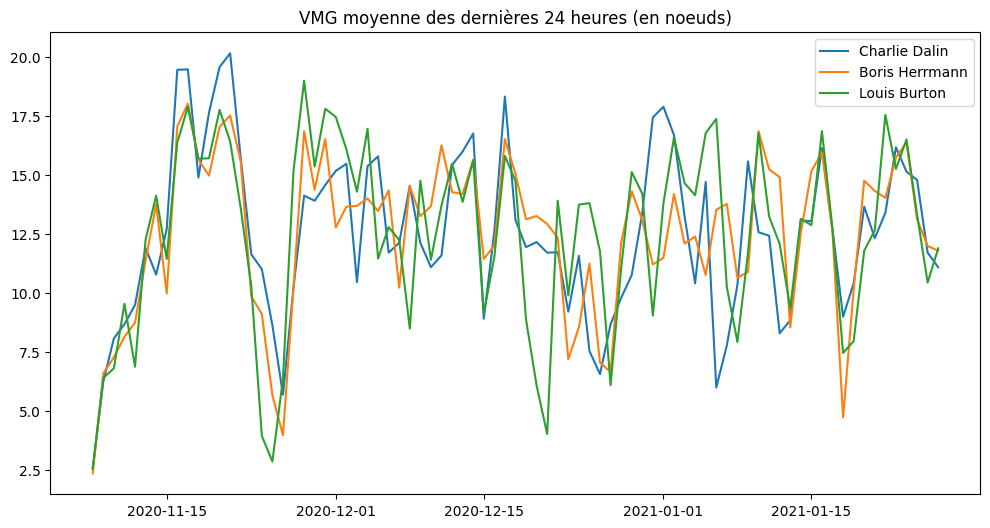

In [19]:
plt.figure(figsize=(12,6))
plt.plot(vg_df.loc[vg_df["Skipper"] == "Charlie Dalin", "VMG_l24h"].resample("D").mean(), label="Charlie Dalin")
plt.plot(vg_df.loc[vg_df["Skipper"] == "Boris Herrmann", "VMG_l24h"].resample("D").mean(), label="Boris Herrmann")
plt.plot(vg_df.loc[vg_df["Skipper"] == "Louis Burton", "VMG_l24h"].resample("D").mean(), label="Louis Burton")
plt.title("VMG moyenne des dernières 24 heures (en noeuds)")
plt.legend()
plt.show()

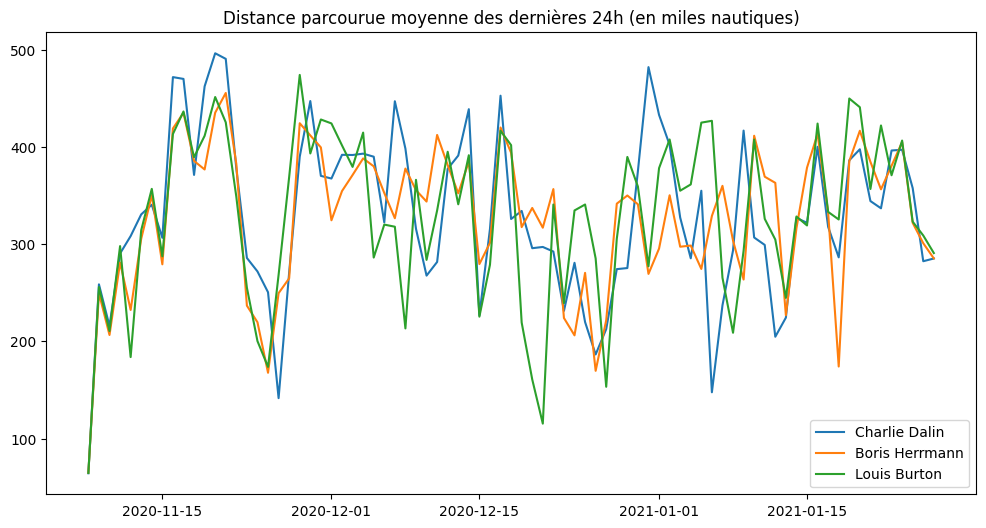

In [20]:
plt.figure(figsize=(12,6))
plt.plot(vg_df.loc[vg_df["Skipper"] == "Charlie Dalin", "Dist_l24h"].resample("D").mean(), label="Charlie Dalin")
plt.plot(vg_df.loc[vg_df["Skipper"] == "Boris Herrmann", "Dist_l24h"].resample("D").mean(), label="Boris Herrmann")
plt.plot(vg_df.loc[vg_df["Skipper"] == "Louis Burton", "Dist_l24h"].resample("D").mean(), label="Louis Burton")
plt.title("Distance parcourue moyenne des dernières 24h (en miles nautiques)")
plt.legend()
plt.show()

## Web Scraping pour récuperer les informations techniques des bateaux

#### Création du dataframe à partir des données de la page web

In [21]:
url = "https://www.vendeeglobe.org/fr/glossaire"
r = requests.get(url)
soup = BeautifulSoup(r.content)

tech_specs = {"Nom_voile": [], "Anciens noms du bateau": [], "Numéro de voile": [], "Architecte": [], "Chantier": [], "Date de lancement": [],
             "Longueur": [], "Largeur": [], "Tirant d'eau": [], "Déplacement (poids)": [], "Nombre de dérives" : [], "Hauteur mât": [],
              "Voile quille": [], "Surface de voiles au près" : [], "Surface de voiles au portant": []}

# <div class="boats-list__popup-infos">
i = 1
for div_tag in soup.findAll('div', {'class': 'boats-list__popup-infos'}):
    h3 = div_tag.find("h3", {"class": "boats-list__popup-title"})
    tech_specs["Nom_voile"] += [h3.text]
    for li_tag in div_tag.findAll("li"):
        m = re.match(r"^([^:]+) : (.+)$", li_tag.text)
        key = m.group(1)
        value = m.group(2)
        tech_specs[key] += [value]
    for key in tech_specs:
        if len(tech_specs[key]) < i:
            tech_specs[key] += [np.nan]
    i += 1

In [22]:
tech_df = pd.DataFrame(tech_specs)
tech_df

,Nom_voile,Anciens noms du bateau,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,"No Way Back, Vento di Sardegna",FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,PURE - Best Western®,"Gitana Eighty, Synerciel, Newrest-Matmut",FRA 49,Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,TSE - 4MYPLANET,"Famille Mary-Etamine du Lys, Initiatives Coeur...",FRA72,Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Maître CoQ IV,Safran 2 - Des Voiles et Vous,17,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,CHARAL,NaN,08,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
5,LA MIE CÂLINE - ARTISANS ARTIPÔLE,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",FRA 14,Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
6,BUREAU VALLEE 2,Banque Populaire VIII,18,Verdier - VPLP,CDK Technologies,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
7,ONE PLANET ONE OCEAN,Kingfisher - Educacion sin Fronteras - Forum M...,ESP 33,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2
8,GROUPE SÉTIN,"Paprec-Virbac2, Estrella Damm, We are Water, L...",FRA 71,Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",9 t,2 asymétriques,"28,50",basculante sur vérin hydraulique,270 m2,560 m2
9,BANQUE POPULAIRE X,Macif - SMA,FRA30,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2


#### Nettoyage du dataframe

In [23]:
# extraction des valeurs numériques
numeric_cols = ["Longueur", "Largeur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât",
                "Surface de voiles au près", "Surface de voiles au portant"]

for col in numeric_cols:
    tech_df[col] = tech_df[col].str.extract("(\d+([.,]\d+)?)")[0].str.replace(",", ".").astype(float)

In [24]:
# on créé une nouvelle colonne indiquant la présence de foils
tech_df["Has_foil"] = tech_df["Nombre de dérives"].str.contains("foil") * 1
tech_df = tech_df.drop("Nombre de dérives", axis=1)

In [25]:
# Trouver le numéro de voile manquant
vg_df.loc[vg_df["Skipper"]== "Thomas Ruyant", ["Nat", "Sail"]].min()

Nat     FRA
Sail     59
dtype: object

In [26]:
tech_df.loc[tech_df["Nom_voile"] == "LinkedOut", "Numéro de voile"] = "FRA 59"

In [27]:
# utilisons numéro de voile comme clé de jointure pour les 2 dataframes
tech_df["Numéro de voile"] = tech_df["Numéro de voile"].str.replace(' ', '')
vg_df["Num_voile"] = vg_df["Nat"] + vg_df["Sail"]

In [28]:
vg_df = vg_df.drop(["Nat", "Sail"], axis=1)

In [29]:
# vérifions qu'on a bien toutes les clés dans les deux dataframes
set(vg_df["Num_voile"].unique()) - set(tech_df["Numéro de voile"].unique()) 

{'FRA01', 'FRA17', 'FRA18', 'FRA4', 'FRA8', 'FRFRA', 'GBR777', 'MON10', 'SUI7'}

In [30]:
# on corrige les différences
tech_df.loc[tech_df["Nom_voile"] == "Yes We Cam!", "Numéro de voile"] = "FRA01"
tech_df.loc[tech_df["Nom_voile"] == "Maître CoQ IV", "Numéro de voile"] = "FRA17"
tech_df.loc[tech_df["Nom_voile"] == "BUREAU VALLEE 2", "Numéro de voile"] = "FRA18"
tech_df.loc[tech_df["Nom_voile"] == "ARKEA PAPREC", "Numéro de voile"] = "FRA4"
tech_df.loc[tech_df["Nom_voile"] == "CHARAL", "Numéro de voile"] = "FRA8"
tech_df.loc[tech_df["Nom_voile"] == "L'OCCITANE EN PROVENCE", "Numéro de voile"] = "FRFRA"
tech_df.loc[tech_df["Nom_voile"] == "MEDALLIA", "Numéro de voile"] = "GBR777"
tech_df.loc[tech_df["Nom_voile"] == "SEAEXPLORER - YACHT CLUB DE MONACO", "Numéro de voile"] = "MON10"
tech_df.loc[tech_df["Nom_voile"] == "LA FABRIQUE", "Numéro de voile"] = "SUI7"
vg_df.loc[vg_df["Crew"] == "Merci", "Num_voile"] = "FRA69"
tech_df.loc[tech_df["Nom_voile"] == "MERCI", "Numéro de voile"] = "FRA69"

In [31]:
print(vg_df["Num_voile"].nunique())
print(tech_df["Numéro de voile"].nunique())

33
33


In [32]:
import locale
# on récupère le locale courant
mylocale = locale.getlocale()
# on force le locale en français
locale.setlocale(locale.LC_ALL,'fr_FR.UTF-8')
# on peut parser les dates
tech_df["Date de lancement"] = pd.to_datetime(tech_df["Date de lancement"], format="%d %B %Y")
# on reset le locale d'origine
locale.setlocale(locale.LC_ALL, ".".join(mylocale))

'en_US.UTF-8'

In [33]:
# calculons l'ages des voiliers afin de comparer leurs performances
tech_df["Today"] = pd.to_datetime(datetime.date.today())
# Age des voiliers en années
tech_df["Age voilier"] = (tech_df["Today"] - tech_df["Date de lancement"])/np.timedelta64(1,'Y')
tech_df = tech_df.drop("Today", axis=1)

#### Visualisations des données techniques des voiliers

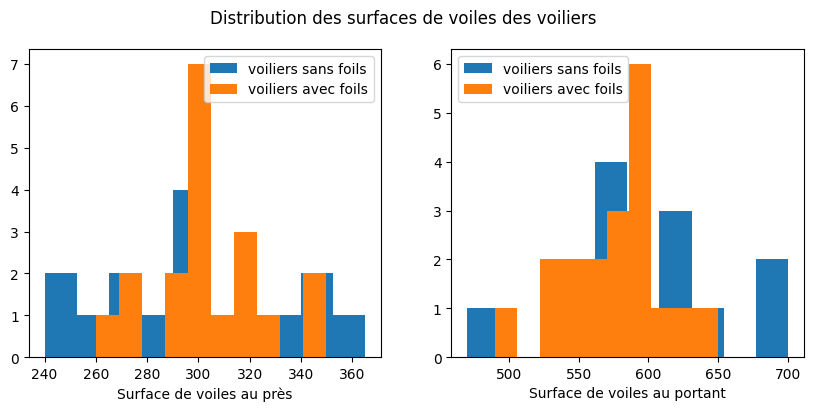

In [34]:
cols = ["Largeur", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant", "Age voilier", "Has_foil"]

c0 = tech_df["Has_foil"] == 0
fig = plt.figure(figsize=(10,4))
# au près
fig.add_subplot(121)
plt.hist(tech_df.loc[c0, "Surface de voiles au près"], label="voiliers sans foils")
plt.hist(tech_df.loc[~c0, "Surface de voiles au près"], label="voiliers avec foils")
plt.xlabel("Surface de voiles au près")
plt.legend()
# au portant
fig.add_subplot(122)
plt.hist(tech_df.loc[c0, "Surface de voiles au portant"], label="voiliers sans foils")
plt.hist(tech_df.loc[~c0, "Surface de voiles au portant"], label="voiliers avec foils")
plt.xlabel("Surface de voiles au portant")
plt.legend()

plt.suptitle("Distribution des surfaces de voiles des voiliers")
plt.legend()
plt.show()

On constate qu'il ya plus de disparité pour les voiliers sans foils

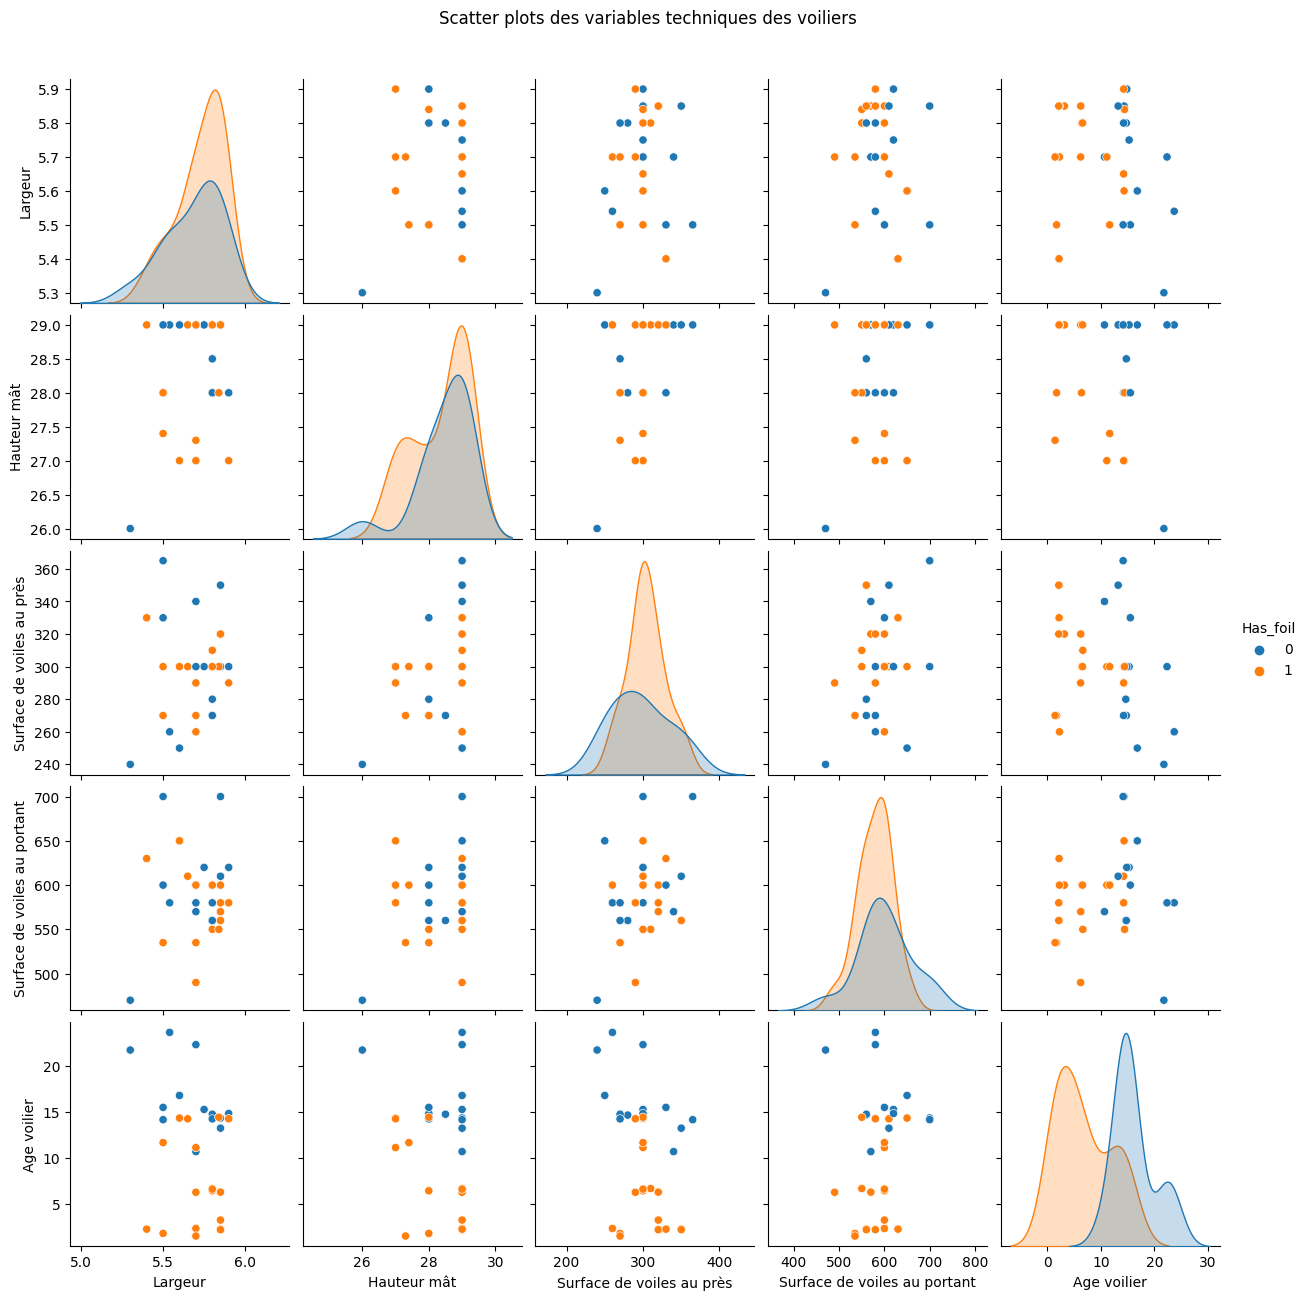

In [35]:
g = sns.pairplot(tech_df[cols], hue="Has_foil", dropna=True)
g.fig.suptitle("Scatter plots des variables techniques des voiliers", y=1.04)
plt.show()

#### Jointure des deux dataframes pour analyses plus détaillées

In [36]:
merged_df = vg_df.reset_index().merge(
    tech_df.drop(["Nom_voile", "Anciens noms du bateau", "Architecte", "Chantier"], axis=1),
    left_on="Num_voile",
    right_on="Numéro de voile")

merged_df = merged_df.set_index("date_time").sort_index()

In [37]:
merged_df

,Rank,Head_l30min,Speed_l30min,VMG_l30min,Dist_l30min,Head_lrep,Speed_lrep,VMG_lrep,Dist_lrep,Head_l24h,...,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant,Has_foil,Age voilier
date_time,,,,,,,,,,,,,,,,,,,,,
2020-11-08 15:26:00,28,238.0,13.8,13.5,0.2,358.0,0.0,0.0,2788.5,187.0,...,18.28,5.60,4.5,7.7,27.0,acier,300.0,650.0,1,14.346633
2020-11-08 15:27:00,20,241.0,22.3,22.3,0.4,357.0,0.0,0.0,2789.3,195.0,...,18.28,5.70,4.5,7.9,27.3,NaN,270.0,535.0,1,1.481208
2020-11-08 15:28:00,14,232.0,7.5,7.2,2.7,357.0,0.0,0.0,2788.4,192.0,...,18.28,5.85,4.5,8.5,29.0,acier forgé,350.0,610.0,0,13.243256
2020-11-08 15:28:00,26,242.0,12.6,12.6,0.6,358.0,0.0,0.0,2788.9,190.0,...,18.28,5.50,4.5,7.8,28.0,acier forgé,270.0,535.0,1,1.768688
2020-11-08 15:28:00,30,237.0,11.4,11.3,0.4,358.0,0.0,0.0,2788.9,188.0,...,18.28,5.50,4.5,8.5,28.0,carbone,330.0,600.0,0,15.512981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 04:30:00,15,4.0,12.8,12.2,6.4,0.0,13.9,12.9,97.3,0.0,...,18.28,5.65,4.5,7.9,29.0,basculante avec vérin,300.0,610.0,1,14.264496
2021-01-27 04:30:00,1,143.0,16.3,0.3,8.1,93.0,13.4,11.4,94.0,87.0,...,18.28,5.85,4.5,8.0,29.0,acier,350.0,560.0,1,2.258773
2021-01-27 04:30:00,14,346.0,16.1,12.2,8.1,347.0,16.1,12.5,112.5,356.0,...,18.28,5.85,4.5,8.0,29.0,acier,320.0,600.0,1,3.222517


## Visualisations sur cartes

In [38]:
import plotly.express as px
from IPython.display import IFrame

# afficher la version html de la carte animée 
# (pour un affichage correct dans la version html du notebook)
if HTML_DISPLAY:
    display(IFrame(src="animated_map.html", width=900, height=600))
# sinon on reconstruit le graphe et on le sauvegarde
else:
    chosen_skipper = ["Alex Thomson", "Charlie Dalin", "Yannick Bestaven", "Jean Le Cam", "Jérémie Beyou", "Kevin Escoffier"]

    map_df = merged_df.loc[merged_df["Skipper"].isin(chosen_skipper), :].between_time(
        start_time='04:20', end_time='04:40')

    map_df = map_df.reset_index()
    map_df["date_time"] = map_df["date_time"].astype(str)

    fig = px.scatter_geo(map_df, lat="Lat_dec", lon="Long_dec",
                         color="Skipper", 
                         hover_name="Crew", 
                         hover_data=["Rank", "date_time","VMG_l24h", "Dist_l24h", "Has_foil"],
                         projection="natural earth", 
                         title="Positions GPS des participants au cours du temps",
                         labels="Skipper",
                         animation_frame="date_time",
                         animation_group="Skipper",
                         opacity=0.5)

    fig.update_traces(mode="lines", ids=chosen_skipper)
    fig.show()
    fig.write_html("animated_map.html")

## Analyses de corrélations et prédictions

### On s'intéresse à l'impact des foils sur la performance des voiliers

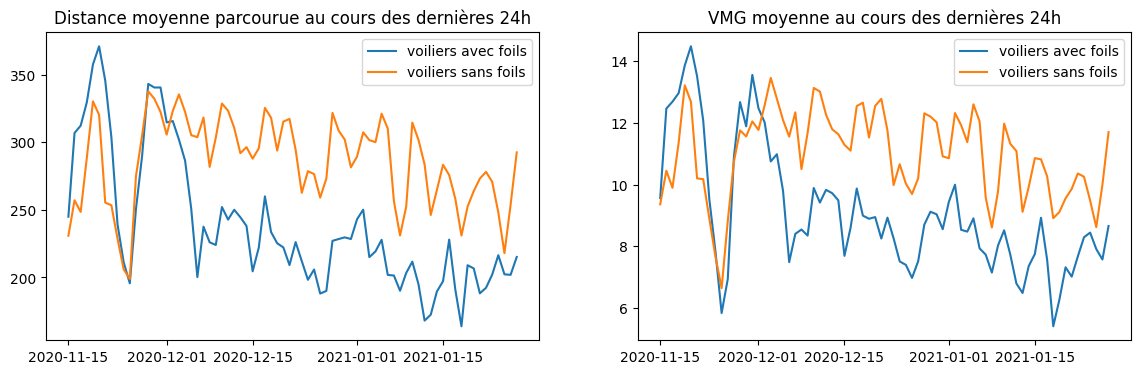

In [39]:
c0 = merged_df["Has_foil"] == 1
d0 = merged_df.index > "2020-11-15"

fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plt.plot(merged_df.loc[c0 & d0, "Dist_l24h"].resample("D").mean(), label="voiliers avec foils")
plt.plot(merged_df.loc[~c0 & d0, "Dist_l24h"].resample("D").mean(), label="voiliers sans foils")
plt.title("Distance moyenne parcourue au cours des dernières 24h")
plt.legend()
fig.add_subplot(122)
plt.plot(merged_df.loc[c0 & d0, "VMG_l24h"].resample("D").mean(), label="voiliers avec foils")
plt.plot(merged_df.loc[~c0 & d0, "VMG_l24h"].resample("D").mean(), label="voiliers sans foils")
plt.title("VMG moyenne au cours des dernières 24h")
plt.legend()
plt.show()

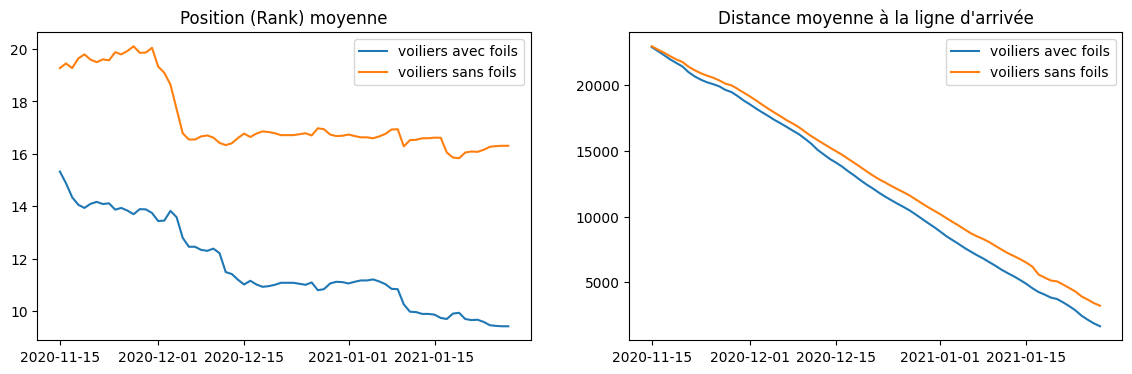

In [40]:
# Ranking moyen des voiliers avec et sans foils
has_foil = merged_df["Has_foil"] == 1
not_retired = merged_df["Retired"] == 0
d0 = merged_df.index > "2020-11-15"

fig = plt.figure(figsize=(14,4))
fig.add_subplot(121)
plt.plot(merged_df.loc[has_foil & not_retired & d0, "Rank"].resample("D").mean(), label="voiliers avec foils")
plt.plot(merged_df.loc[~has_foil & not_retired & d0, "Rank"].resample("D").mean(), label="voiliers sans foils")
plt.title("Position (Rank) moyenne")
plt.legend()
fig.add_subplot(122)
plt.plot(merged_df.loc[has_foil & not_retired & d0, "DTF"].resample("D").mean(), label="voiliers avec foils")
plt.plot(merged_df.loc[~has_foil & not_retired & d0, "DTF"].resample("D").mean(), label="voiliers sans foils")
plt.title("Distance moyenne à la ligne d'arrivée")
plt.legend()
plt.show()


In [41]:
# Pourcentage de participants ayant abandonné
is_retired = merged_df["Retired"] == 1
aband = merged_df.loc[has_foil & is_retired, "Skipper"].nunique() / merged_df.loc[has_foil, "Skipper"].nunique()
print(f"Pourcentage de voiliers avec foils ayant abandonné la course : {aband*100:.2f}%")

aband = merged_df.loc[~has_foil & is_retired, "Skipper"].nunique() / merged_df.loc[~has_foil, "Skipper"].nunique()
print(f"Pourcentage de voiliers sans foils ayant abandonné la course : {aband*100:.2f}%")

Pourcentage de voiliers avec foils ayant abandonné la course : 47.37%
Pourcentage de voiliers sans foils ayant abandonné la course : 7.14%


**Les voiliers avec foils sont plus performants mais aussi plus fragiles !**

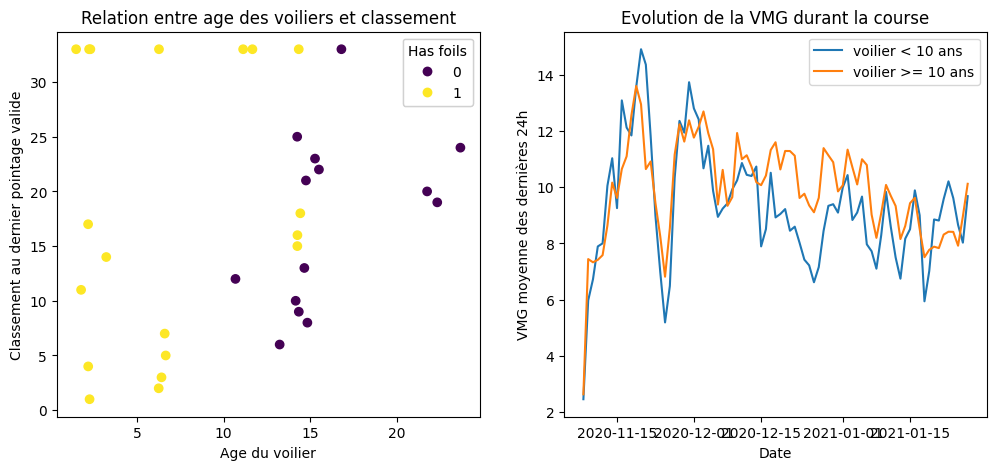

In [42]:
last_stats = merged_df.loc[(merged_df.index == merged_df.index.max()), :]
last_stats

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# scatter plot
scatter = ax1.scatter(last_stats["Age voilier"], last_stats["Rank"], c=last_stats["Has_foil"])

legend1 = ax1.legend(*scatter.legend_elements(), loc="best", title="Has foils")
ax1.add_artist(legend1)
ax1.set_xlabel("Age du voilier")
ax1.set_ylabel("Classement au dernier pointage valide")
ax1.set_title("Relation entre age des voiliers et classement")

# VMG vs time plot
age1 = merged_df["Age voilier"] < 10
ax2.plot(merged_df.loc[age1, "VMG_l24h"].resample("D").mean(), label="voilier < 10 ans")
ax2.plot(merged_df.loc[~age1, "VMG_l24h"].resample("D").mean(), label="voilier >= 10 ans")
ax2.set_xlabel("Date")
ax2.set_ylabel("VMG moyenne des dernières 24h")
ax2.set_title("Evolution de la VMG durant la course")
ax2.legend()
plt.show()

On constate que les voiliers plus récents (et donc avec foils) trustent les premières places (top 5), mais des voiliers plus anciens (>10ans) arrivent à se hisser dans le top10 (et sont plus nombreux dans le top15) malgré l'absence de foils.

En outre, les voiliers de moins de 10 ans ne sont pas forcément plus rapide que les voiliers plus anciens. Ces voiliers de courses sont certainement très bien entretenus et bénéficient d'améliorations au cours des années.

## Machine Learning
### Prédiction de la présence de foils
On commence avec un premier modèle simple sur 4 variables. On n'utilise pas la variable "Age voilier" car ce serait trop évident

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# on utilise un TimeSeriesSplit pour la cross-validation afin de s'assurer que les données
# du fold de validation sont bien dans le "futur" par rapport aux données d'entrainement
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

features = ["VMG_l24h", "DTL", "DTF", "Rank", "Retired"]
X = merged_df.loc[:, features]
Y = merged_df["Has_foil"]

# calcul du poids des classes
class_1 = merged_df["Has_foil"].sum() / merged_df.shape[0]
class_0 = 1 - class_1

# le modèle complet : on standardise les données numériques puis on utilise une regression logistique
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.01, class_weight={1: class_1, 0: class_0})
)

scores = np.zeros((N_SPLITS,2))

# boucle de cross-validation
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    clf.fit(X.iloc[train_index,:], Y.iloc[train_index])
    preds = clf.predict(X.iloc[test_index,:])
    # accuracy
    scores[i,0] = clf.score(X.iloc[test_index,:], Y.iloc[test_index])
    # f1 score
    scores[i,1] = f1_score(Y.iloc[test_index], preds)

print(f"Scores de la Regression Logistique avec les features : {features}\n")
print(f"Accuracy moyenne sur la cross-validation : {np.mean(scores[:,0])*100:.2f}%")
print(f"F1-score moyen sur la cross-validation : {np.mean(scores[:,1])*100:.2f}%")

Scores de la Regression Logistique avec les features : ['VMG_l24h', 'DTL', 'DTF', 'Rank', 'Retired']

Accuracy moyenne sur la cross-validation : 67.53%
F1-score moyen sur la cross-validation : 75.52%


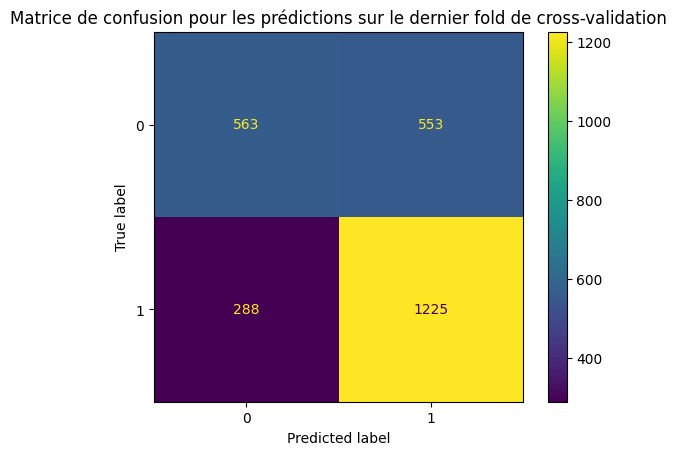

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# affichage de la matrice de confusion pour le dernier fold
cm = confusion_matrix(Y.iloc[test_index], preds, labels=clf[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf[1].classes_)
disp.plot()
plt.title("Matrice de confusion pour les prédictions sur le dernier fold de cross-validation")
plt.show()

On ajoute les données techniques des bateaux dans les features afin d'essayer d'améliorer les prédictions

In [45]:
tech_features = ["Longueur", "Largeur", "Tirant d'eau", "Hauteur mât",
                 "Surface de voiles au près", "Surface de voiles au portant"]
new_feats = features + tech_features


X = merged_df.loc[:, new_feats]
Y = merged_df["Has_foil"]

# calcul du poids des classes
class_1 = merged_df["Has_foil"].sum() / merged_df.shape[0]
class_0 = 1 - class_1

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=0.01, class_weight={1: class_1, 0: class_0})
)

scores = np.zeros((N_SPLITS,2))

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    clf.fit(X.iloc[train_index,:], Y.iloc[train_index])
    preds = clf.predict(X.iloc[test_index,:])
    # accuracy
    scores[i,0] = clf.score(X.iloc[test_index,:], Y.iloc[test_index])
    # f1 score
    scores[i,1] = f1_score(Y.iloc[test_index], preds)

print(f"Scores de la Regression Logistique avec les features : {new_feats}\n")
print(f"Accuracy moyenne sur la cross-validation : {np.mean(scores[:,0])*100:.2f}%")
print(f"F1-score moyen sur la cross-validation : {np.mean(scores[:,1])*100:.2f}%")

Scores de la Regression Logistique avec les features : ['VMG_l24h', 'DTL', 'DTF', 'Rank', 'Retired', 'Longueur', 'Largeur', "Tirant d'eau", 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']

Accuracy moyenne sur la cross-validation : 76.61%
F1-score moyen sur la cross-validation : 82.10%


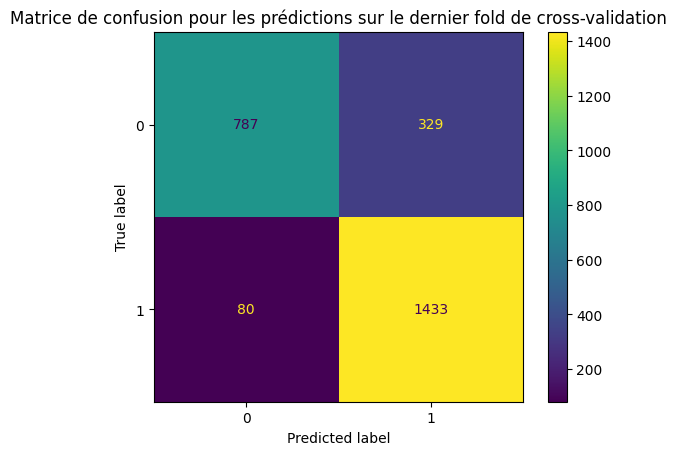

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# affichage de la matrice de confusion pour le dernier fold
cm = confusion_matrix(Y.iloc[test_index], preds, labels=clf[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf[1].classes_)
disp.plot()
plt.title("Matrice de confusion pour les prédictions sur le dernier fold de cross-validation")
plt.show()

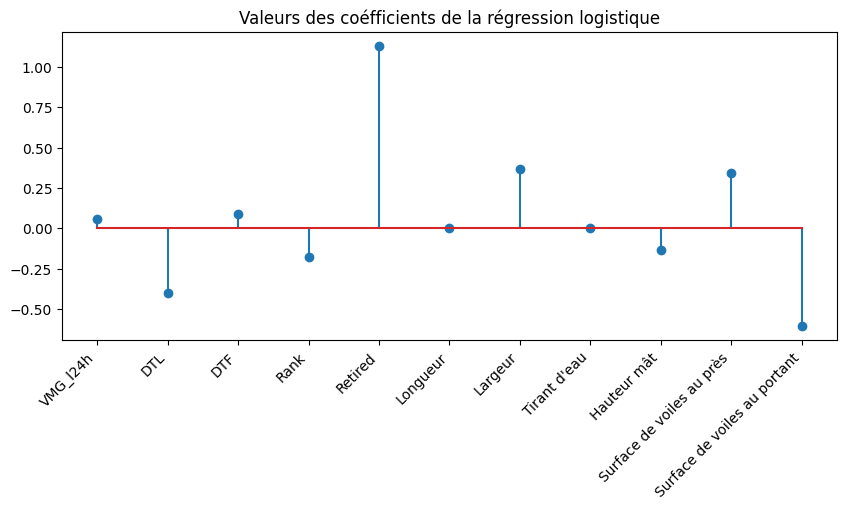

In [47]:
# plot des coéfficients pour la regression logistique sur le dernier fold
plt.figure(figsize=(10,4))
plt.stem(X.columns, clf[1].coef_.flatten())
plt.xticks(rotation=45, ha="right")
plt.title("Valeurs des coéfficients de la régression logistique")
plt.show()

* On note que les variables les plus importantes sont "Retired", "Surface de voiles au portant", "DTL", "Largeur" et "Surface de voiles au près".
* Les coéfficients pour "Longueur" et "Tirant d'eau" sont à 0, en effet ces variables n'ont quasiment aucune variance (les valeurs sont les memes pour tous les voiliers) donc inutile pour modèle

### Prédiction du Rank
* On va tenter de prédire le Rank à partir des données.
* On commence par une **Régression Linéaire** avec pénalisation l2

In [48]:
from sklearn.linear_model import LinearRegression, Ridge

# on utilise un TimeSeriesSplit pour la cross-validation afin de s'assurer que les données
# du fold de validation sont bien dans le "futur" par rapport aux données d'entrainement
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)


features = ["VMG_l24h", "DTL", "DTF", "Retired", "Age voilier" ] + tech_features
X = merged_df.loc[:, features]
Y = merged_df["Rank"]


# le modèle complet : on standardise les données numériques puis on utilise une regression linéaire
# avec pénalisation l2
reg = make_pipeline(
    StandardScaler(),
    Ridge(alpha=3e3)
)

scores = np.zeros((N_SPLITS,2))

# boucle de cross-validation
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    reg.fit(X.iloc[train_index,:], Y.iloc[train_index])
    preds = reg.predict(X.iloc[test_index,:])
    # R2 score
    scores[i,0] = reg.score(X.iloc[test_index,:], Y.iloc[test_index])
    # RMSE
    scores[i,1] = np.sqrt(1/len(preds) * np.sum((Y.iloc[test_index] - preds)**2))

print(f"Scores de la Regression Linéaire avec les features : {features}\n")
print(f"Coéfficient R2 moyen sur la cross-validation : {np.mean(scores[:,0])*100:.2f}%")
print(f"Moyenne des RMSE sur la cross-validation : {np.mean(scores[:,1]):.2f}")

Scores de la Regression Linéaire avec les features : ['VMG_l24h', 'DTL', 'DTF', 'Retired', 'Age voilier', 'Longueur', 'Largeur', "Tirant d'eau", 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']

Coéfficient R2 moyen sur la cross-validation : 85.33%
Moyenne des RMSE sur la cross-validation : 3.82


* Enfin on essaie un **SVM** pour voir si un algorithme pouvant détecter des relations non linéaires pourrait améliorer le résultat

In [49]:
from sklearn.svm import SVR

reg = make_pipeline(
    StandardScaler(),
    SVR(C=2)
)

scores = np.zeros((N_SPLITS,2))

# boucle de cross-validation
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    reg.fit(X.iloc[train_index,:], Y.iloc[train_index])
    preds = reg.predict(X.iloc[test_index,:])
    # R2 score
    scores[i,0] = reg.score(X.iloc[test_index,:], Y.iloc[test_index])
    # RMSE
    scores[i,1] = np.sqrt(1/len(preds) * np.sum((Y.iloc[test_index] - preds)**2))

print(f"Scores du SVM avec les features : {features}\n")
print(f"Coéfficient R2 moyen sur la cross-validation : {np.mean(scores[:,0])*100:.2f}%")
print(f"Moyenne des RMSE sur la cross-validation : {np.mean(scores[:,1]):.2f}")

Scores du SVM avec les features : ['VMG_l24h', 'DTL', 'DTF', 'Retired', 'Age voilier', 'Longueur', 'Largeur', "Tirant d'eau", 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']

Coéfficient R2 moyen sur la cross-validation : 90.46%
Moyenne des RMSE sur la cross-validation : 2.97
